##  RNN (Recurrent Neural Network) 循环神经网络

- 自归回模型 Autoregression (马尔可夫模型)
- 隐变量自回归模型
    - RNN `循环神经网络`
    - f(x, h) = (x@wx + h@wh) + b = output, h+1
    
![image](https://zh.d2l.ai/_images/rnn.svg)

### 循环神经网络结构

In [1]:
import torch
import torch.nn as nn

In [3]:
x = torch.randn(3, 1)  # [batch_size, input_size]
h0 = torch.randn(3, 4)  # [batch_size, hiiden_size]

weight_x = torch.randn(1, 4)  # [input_size, hidden_size]
weight_h = torch.randn(4, 4)  # [hidden_size, hidden_size]

In [15]:
h1 = torch.cat((x, h), dim=1) @ torch.cat((weight_x, weight_h), dim=0)
h1

tensor([[-0.3609, -4.3567,  1.1938,  2.4027],
        [-2.3005, -4.8092,  0.9540,  3.4635],
        [-1.1433, -4.6062, -1.2398,  3.5031]])

In [17]:
weight_output = torch.randn(4, 10) # [hidden_size, output_size]
output = h1 @ weight_output
output.shape  # [batch_size, output_size]

torch.Size([3, 10])

In [68]:
class RNNCell(nn.Module):
    """ 循环神经网络单元 """
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.weight_hidden = nn.Linear(input_size+hidden_size, hidden_size)
        self.weight_output = nn.Linear(hidden_size, output_size)
          
    def forward(self, x, hidden=None, batch_first=True):
        """ 前向传播方法 """
        # x: [batch_size, seq_len, input_size(embedding_size)]
        # hidden: [batch_size, hidden_size]
        if hidden is None:
            hidden = torch.randn(x.shape[0], self.hidden_size)
        if batch_first:
            x = x.transpose(0, 1)  # x: [seq_len, batch_size, input_size(embedding_size)]
        
        hiddens = []
        outputs = []
        for step in range(x.shape[0]):
            # x[step]: [batch_size, input_size]
            # hidden: [batch_size, hidden_size]
            combined = torch.cat((x[step], hidden), dim=1)  # combined: [batch_size, input_size+hidden_size]
            hidden = torch.tanh(self.weight_hidden(combined))  # hidden: [batch_size, hidden_size]
            output = torch.tanh(self.weight_output(hidden))  # output: [batch_size, output_size]
            
            hiddens.append(hidden)
            outputs.append(output)
        
        return torch.stack(outputs).transpose(0, 1)

In [74]:
class RNN(nn.Module):
    """ 循环神经网络 """
    def __init__(self):
        super().__init__()
        self.rnn = nn.Sequential(RNNCell(16, 32, 64), 
                                 nn.Tanh(), 
                                 RNNCell(64, 128, 256), 
                                 nn.Tanh())
        
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(10*256, 2))
        
    def forward(self, x):
        """ 前向传播方法 """
        output = self.rnn(x)
        return self.fc(output)

In [75]:
batch_size = 16
seq_len = 10

input_size = 16
hidden_size = 32
output_size = 64

model = RNNCell(input_size, hidden_size, output_size)

x = torch.randn(batch_size, seq_len, input_size)
outputs = model(x)

In [79]:
x.shape

torch.Size([16, 10, 16])

In [81]:
model = RNN()
output = model(x)
output

tensor([[-0.0850, -0.0285],
        [-0.0270,  0.0439],
        [-0.0709,  0.0682],
        [ 0.0505, -0.0619],
        [-0.0176, -0.0749],
        [-0.0059,  0.0223],
        [ 0.0566, -0.0268],
        [ 0.0534, -0.0296],
        [ 0.0128,  0.0489],
        [ 0.0314, -0.0501],
        [ 0.0638,  0.0332],
        [ 0.0377, -0.0062],
        [ 0.0488, -0.0040],
        [ 0.0104,  0.0581],
        [ 0.0048, -0.0259],
        [ 0.0195, -0.0617]], grad_fn=<AddmmBackward>)

### 基于循环神经网络的文本情感分析

#### 1 构建模型

In [105]:
class TextSentimentClassifer(nn.Module):
    """ 文本情感分类器 """
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, seq_len):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(input_size=embedding_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers)
        self.fc = nn.Sequential(nn.Flatten(), 
                                nn.ReLU(), 
                                nn.Linear(seq_len*hidden_size, 2))
        
    def forward(self, x):
        """ 前向传播方法 """
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        h0 = torch.randn(self.num_layers, embedded.shape[0], self.hidden_size)
        output, hn = self.rnn(embedded.transpose(0, 1), h0)  # output: [seq_len, batch_size, hidden_size]
        # output: [batch_size, seq_len, hidden_size]
        return self.fc(output.transpose(0, 1))

In [110]:
model = TextSentimentClassifer(1250, 16, 32, 2, 10)
x = torch.zeros(8, 10, dtype=torch.long)
output = model(x)
output.shape

torch.Size([8, 2])

#### 2 构建数据集

In [199]:
import pandas as pd

df_reviews = pd.read_csv("../data/Amazon-Product-Reviews - Amazon Product Review.csv").dropna()[["review_body", "sentiment"]]
# df_reviews = df_reviews.head(1000)  # ToDo: 使用全量数据
df_reviews

,review_body,sentiment
0,Great love it,1
1,Lots of ads<br />Slow processing speed<br />Oc...,0
2,Excellent unit. The versatility of this table...,1
3,I bought this on Amazon Prime so I ended up bu...,1
4,All Amazon products continue to meet my expect...,1
...,...,...
30841,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,1
30842,I'm writing this review with the benefit of be...,1
30843,"I purchased this Kindle for my grandma, becaus...",1
30844,I bought my tablet Fire HD 7 at Best Buy on th...,1


In [200]:
class Vocab:
    """ 用于存储单词词元的词典类 """
    def __init__(self):
        self.word2idx = {"<PAD>": 0}
        self.idx2word = ["<PAD>"]
        
    def add(self, word):
        """ 用于向词典中添加新的单词 """
        if word not in self.idx2word:
            self.word2idx[word] = len(self.idx2word)
            self.idx2word.append(word)
            
    def __len__(self):
        """ 用于返回该词典的长度 """
        return len(self.idx2word)

In [201]:
from typing import List

def text_preprocessing(doc: str)->List[str]:
    """ 文本预处理函数 """
    stop_words = ["(", ")", ",", ".", "?", "!", "=", "<", ">", "[", "]", ""]
    doc = doc.replace("<br />", " ")
    return [item.lower() for item in doc.strip().split(" ") if item not in stop_words]

vocab = Vocab()

data = []
for idx, row in df_reviews.iterrows():
    word_list = text_preprocessing(row.review_body)
    for word in word_list:
        vocab.add(word)
    data.append([vocab.word2idx.get(word) for word in word_list])
        
len(vocab)

35792

In [178]:
from torch.utils.data import Dataset, DataLoader

class AmazonReviewsDataset(Dataset):
    """ 商品评价数据集 """
    def __init__(self, data, label, seq_len=30):
        self.data = []
        for line in data:
            if len(line)>=seq_len:
                self.data.append(line[:seq_len])
            else:
                self.data.append(line + [0]*(seq_len-len(line)))
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), 
    torch.tensor(self.label[idx], dtype=torch.long)
        
dataset = AmazonReviewsDataset(data, df_reviews.sentiment.values)

In [183]:
x, y = dataset[:16]
x.shape, y.shape

(torch.Size([16, 30]), torch.Size([16]))

#### 3 训练模型

In [184]:
batch_size = 16
embedding_size = 32
hidden_size = 64
num_layers = 2
seq_len = 30

dataset = AmazonReviewsDataset(data, df_reviews.sentiment.values, seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [186]:
def train_model(model, dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    total_loss = 0.
    for x, y in dataloader:
        y_hat = model(x)
        loss = loss_func(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss/len(dataloader)

In [189]:
model = TextSentimentClassifer(len(vocab), embedding_size, hidden_size, num_layers, seq_len)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [190]:
n_epoch = 50

train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {round(loss, 4)}")

Epoch 1 loss: 0.5132
Epoch 2 loss: 0.4335
Epoch 3 loss: 0.3509
Epoch 4 loss: 0.2957
Epoch 5 loss: 0.2018
Epoch 6 loss: 0.1381
Epoch 7 loss: 0.097
Epoch 8 loss: 0.0717
Epoch 9 loss: 0.0501
Epoch 10 loss: 0.0339
Epoch 11 loss: 0.028
Epoch 12 loss: 0.0177
Epoch 13 loss: 0.0113
Epoch 14 loss: 0.0103
Epoch 15 loss: 0.0083
Epoch 16 loss: 0.0054
Epoch 17 loss: 0.0066
Epoch 18 loss: 0.005
Epoch 19 loss: 0.0035
Epoch 20 loss: 0.0032
Epoch 21 loss: 0.0024
Epoch 22 loss: 0.0016
Epoch 23 loss: 0.0015
Epoch 24 loss: 0.0014
Epoch 25 loss: 0.0011
Epoch 26 loss: 0.001
Epoch 27 loss: 0.0009
Epoch 28 loss: 0.0007
Epoch 29 loss: 0.0007
Epoch 30 loss: 0.0006
Epoch 31 loss: 0.0006
Epoch 32 loss: 0.0005
Epoch 33 loss: 0.0005
Epoch 34 loss: 0.0004
Epoch 35 loss: 0.0004
Epoch 36 loss: 0.0004
Epoch 37 loss: 0.0004
Epoch 38 loss: 0.0003
Epoch 39 loss: 0.0003
Epoch 40 loss: 0.0003
Epoch 41 loss: 0.0003
Epoch 42 loss: 0.0003
Epoch 43 loss: 0.0002
Epoch 44 loss: 0.0002
Epoch 45 loss: 0.0002
Epoch 46 loss: 0.0002
E

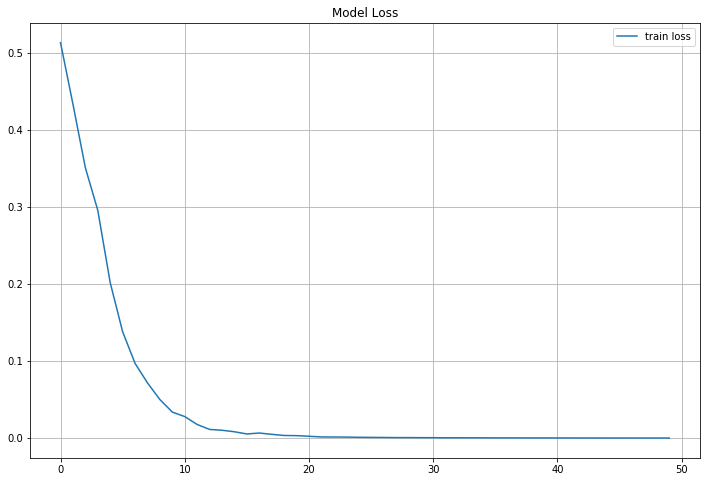

In [191]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label="train loss")
plt.title("Model Loss")
plt.grid()
plt.legend()
plt.show()